In [1]:
import os
from glob import glob
import random
import time
import copy
import datetime as dt
import warnings
from collections import Counter
import itertools
import shutil
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import wandb
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import albumentations as A
import albumentations.pytorch
import sklearn
from sklearn.metrics import confusion_matrix
from joblib import parallel_backend
import ttach as tta
import timm
from timm.models.layers import Conv2dSame
from sklearn.metrics import f1_score

In [2]:
#path = '../Data/car_dataset_sample/'
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'

#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  161526
Image_labels: 161526


In [2]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  290400
Image_labels: 290400


In [3]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211012_NI_071_18_WH_A_P_01_034.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
1,C_211012_NI_071_18_WH_A_T_03_022.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
2,C_211012_NI_071_18_WH_A_P_01_064.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
3,C_211012_NI_071_18_WH_A_P_01_051.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
4,C_211012_NI_071_18_WH_A_P_01_058.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
...,...,...,...
290395,C_211129_JE_087_21_WH_A_T_03_004.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290396,C_211129_JE_087_21_WH_A_T_03_010.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290397,C_211129_JE_087_21_WH_A_P_01_057.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290398,C_211129_JE_087_21_WH_A_P_01_011.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021


In [6]:
train['image_id'][0][24]

'P'

In [14]:
train.loc[0]['dir']

'../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A'

In [5]:
first = le.inverse_transform([100])
first

array(['닛산/알티마/2018'], dtype='<U18')

In [4]:
train['label'].value_counts()

벤츠/E-Class/2017       3566
현대/코나/2018            2755
기아/모닝/2017            2721
기아/K3/2019            2563
기아/스포티지/2018          2471
                      ... 
지프/랭글러/2021             91
쉐보레/볼트EV/2017           90
BMW/X3/2020             89
미니/Countryman/2021      79
지프/랭글러/2018             70
Name: label, Length: 370, dtype: int64

In [4]:
train['label'].value_counts().loc[lambda x : x > 900]

벤츠/E-Class/2017    3566
현대/코나/2018         2755
기아/모닝/2017         2721
기아/K3/2019         2563
기아/스포티지/2018       2471
                   ... 
현대/코나/2020          940
쉐보레/스파크/2020        938
현대/스타렉스/2020        937
현대/팰리세이드/2020       935
기아/니로/2019          923
Name: label, Length: 134, dtype: int64

In [4]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

Index(['BMW/3시리즈/2019', 'BMW/3시리즈/2020', 'BMW/5시리즈/2019', 'BMW/5시리즈/2020',
       'BMW/5시리즈/2021', 'BMW/7시리즈/2017', 'BMW/7시리즈/2018', 'BMW/7시리즈/2019',
       'BMW/7시리즈/2020', 'BMW/X3/2017',
       ...
       '현대/코나/2021', '현대/투싼/2021', '현대/포터2/2018', '현대/포터2/2019', '현대/포터2/2020',
       '현대/포터2/2021', '혼다/CR-V/2017', '혼다/CR-V/2021', '혼다/어코드/2017',
       '혼다/어코드/2021'],
      dtype='object', length=236)

In [5]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train['id'] = train.index
train
# idx

,image_id,dir,label,id
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018,0
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018,1
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018,2
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018,3
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018,4
...,...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020,206641
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020,206642
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020,206643
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020,206644


In [6]:
path = '../Data/car_dataset_sample/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  1897
Image_labels: 1897


In [7]:
test_df = pd.DataFrame(img_names, columns=['image_id'])
test_df['dir'] = test_df['image_id'].apply(lambda x: os.path.dirname(x))
test_df['image_id'] = test_df['image_id'].apply(lambda x: os.path.basename(x))
test_df['label'] = img_labels

label_value = []
for i, di in enumerate(test_df['dir']):
    dir_l = di[30:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

# label_value
test_df['label'] = label_value
test = test_df


# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = test[test['label'] == low_data[i]].index
    test.drop(idx, inplace=True)
test.reset_index(inplace=True, drop=True)
test['id'] = test.index
test
# idx

,image_id,dir,label,id
0,C_210819_SS_097_18_WH_A_T_03_023.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,0
1,C_210819_SS_097_18_WH_A_T_03_002.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,1
2,C_210819_SS_097_18_WH_A_P_01_001.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,2
3,C_211025_SS_097_18_GR_A_P_01_059.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,3
4,C_211025_SS_097_18_GR_A_P_01_054.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,쌍용/티볼리/2018,4
...,...,...,...,...
1018,C_211124_BE_014_19_BK_C_P_01_061.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,1018
1019,C_211124_BE_014_19_BK_C_P_01_023.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,1019
1020,C_211112_BE_014_19_WH_C_T_03_012.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,1020
1021,C_211112_BE_014_19_WH_C_T_03_010.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,벤츠/E-Class/2019,1021


In [8]:
label_value = train['label'].values
label_value
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label,id
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83,0
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83,1
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83,2
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83,3
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83,4
...,...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69,206641
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69,206642
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69,206643
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69,206644


In [9]:
# 인코딩한 데이터로 변환
le_encoded = le.transform(test['label'])
#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
test['label'] = new_cat
test

,image_id,dir,label,id
0,C_210819_SS_097_18_WH_A_T_03_023.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,83,0
1,C_210819_SS_097_18_WH_A_T_03_002.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,83,1
2,C_210819_SS_097_18_WH_A_P_01_001.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,83,2
3,C_211025_SS_097_18_GR_A_P_01_059.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,83,3
4,C_211025_SS_097_18_GR_A_P_01_054.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2018_...,83,4
...,...,...,...,...
1018,C_211124_BE_014_19_BK_C_P_01_061.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,68,1018
1019,C_211124_BE_014_19_BK_C_P_01_023.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,68,1019
1020,C_211112_BE_014_19_WH_C_T_03_012.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,68,1020
1021,C_211112_BE_014_19_WH_C_T_03_010.jpg,../Data/car_dataset_sample/BE_벤츠/014_E-Class/2...,68,1021


In [4]:
CFG = {
    'IMG_SIZE':600,
    'FOLD_NUM':10,
    'EPOCHS':40,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':4,
    'SEED':42,
    'NUM_WORKERS': 6,
}

In [63]:
transform_train_P = A.Compose(
    [   
        # A.RandomResizedCrop(
        #     height=CFG['IMG_SIZE'], 
        #     width=CFG['IMG_SIZE'], 
        #     scale=(0.32, 0.34),
        #     ratio=(0.90, 1.10),
        #     always_apply=True
        #     ),
        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
        #A.pytorch.transforms.ToTensorV2()
        ])
transform_train_T = A.Compose(
    [
        A.CenterCrop(always_apply=True, p=1.0, height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE']),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
        #A.pytorch.transforms.ToTensorV2()
        ])
transform_test = A.Compose(
    [
        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
        A.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
        #A.pytorch.transforms.ToTensorV2()
        ])

In [66]:
class ARTDataset(Dataset):
    def __init__(self, phase, data, transform_p, transform_t) -> None:
        super().__init__()
        df = data.sort_values(by=['id'])
        self.phase = phase
        self.root = df['dir']
        self.images = df['image_id']
        self.transform_p = transform_p
        
        if self.phase != 'test':
            self.label = df['label']
            self.transform_t = transform_t
            

    def __getitem__(self, index):
        
        if self.phase != 'test':
            label = int(self.label.iloc[index])
        print(f'index={index}')
        image_id = self.images.iloc[index]
        image_dir = self.root.iloc[index]

        image_path = f'{image_dir}/{image_id}'
        temp = Image.open(image_path).convert("RGB")
        image = np.array(temp).copy()
        temp.close()

        if self.transform_t :
            if image_id[24] =='P':
                transformed = self.transform_p(image=image)
                print("p")
            else:
                transformed = self.transform_t(image=image)
                print("T")
        else:
            transformed = self.transform_p(image=image)
        
       
        print(image[0])
        plt.figure(figsize=(10,10))
        plt.subplot(2,2,1)
        plt.imshow(image, cmap=plt.cm.binary)
        image = transformed['image']
        plt.subplot(2,2,2)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.show()
        
        if self.phase != 'test':
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.images)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index=0
p
[[116 151  25]
 [116 151  25]
 [118 153  25]
 ...
 [121 100 107]
 [121 100 107]
 [121 100 107]]


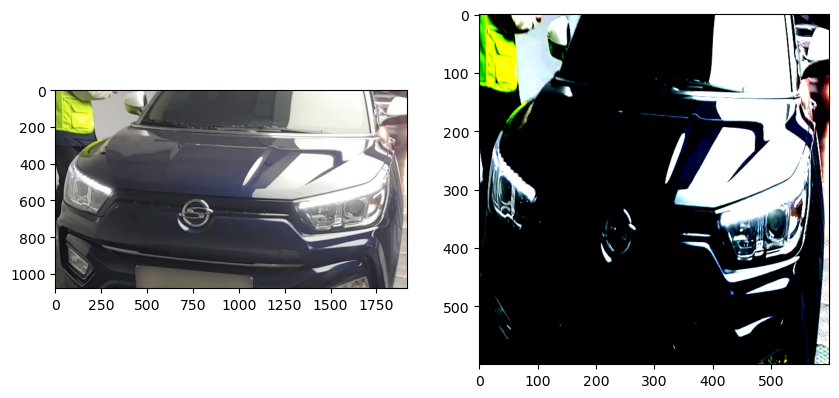

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index=1
p
[[248 247 245]
 [248 247 245]
 [248 247 245]
 ...
 [ 55  55  83]
 [ 55  55  83]
 [ 56  56  84]]


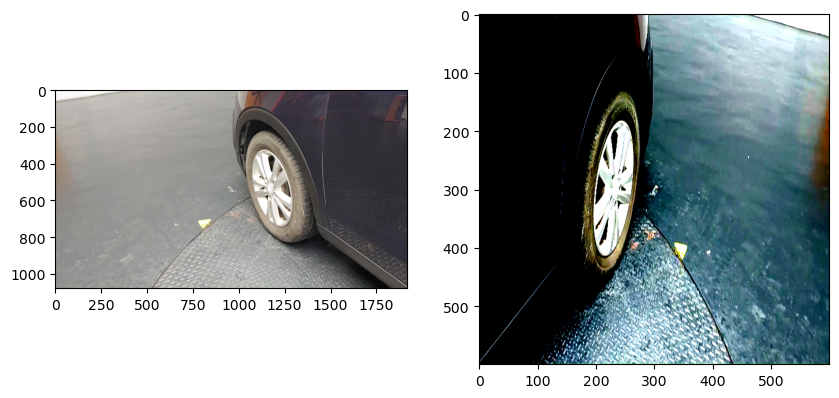

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index=2
p
[[155 152 143]
 [155 152 143]
 [155 152 143]
 ...
 [201 197 188]
 [196 192 183]
 [192 188 179]]


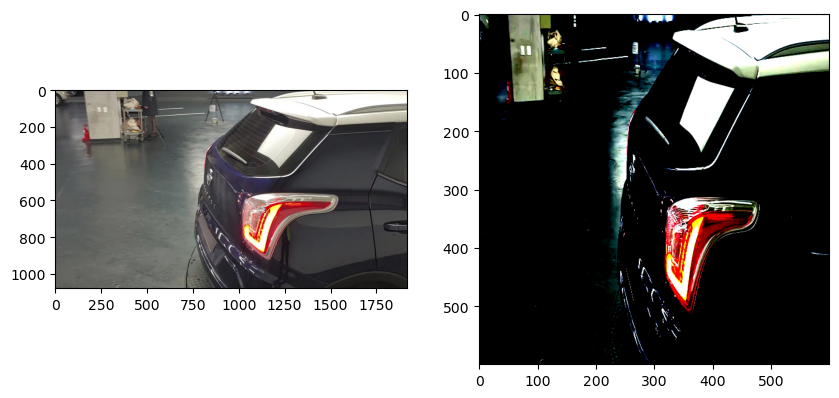

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index=3
T
[[ 70  69  64]
 [ 70  69  64]
 [ 70  69  64]
 ...
 [125 125 127]
 [124 124 126]
 [124 124 126]]


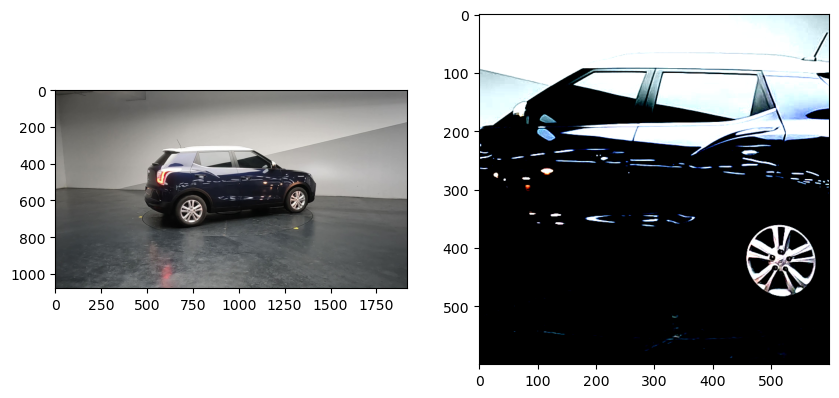

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index=4
T
[[102 101  97]
 [102 101  97]
 [102 101  97]
 ...
 [156 155 153]
 [156 155 153]
 [156 155 153]]


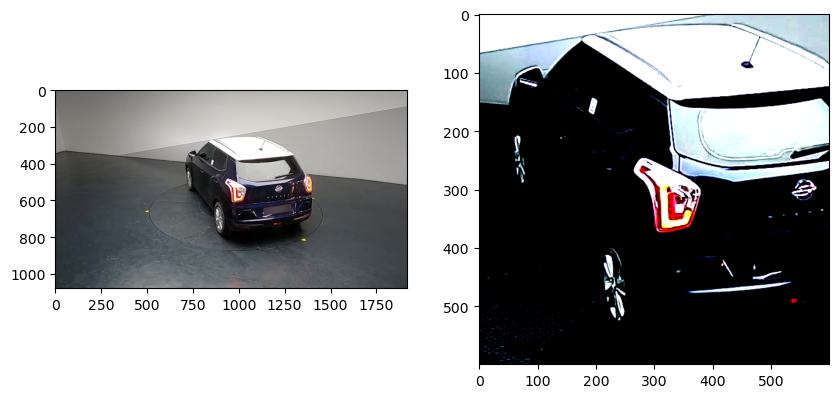

In [67]:
train_index = [1,2,3,4,5]
data_train = train.loc[train_index]
#data_validation = train.loc[valid_index]
#print(data_train['id'])
# print(f'train_index={train_index[0]}')
# print(f'valid_index={valid_index[0]}')
train_dataset = ARTDataset('train', data_train, transform_p=transform_train_P, transform_t=transform_train_T)
#validation_dataset = ARTDataset('validation', data_validation, transform_p=transform_train_P, transform_t=transform_train_T)
for i in range(5):
   train_dataset[i]

In [21]:
dist.destroy_process_group()

In [ ]:
%run noisy_student_b7.ipynb

cls_cnts: 134
num_samples:185981


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


traning start
--------------------------------------------------
Fold: 0
Epoch 0/39
training


  0%|          | 0/46496 [00:00<?, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


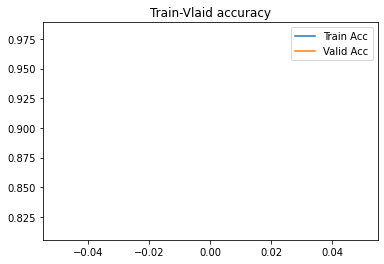

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


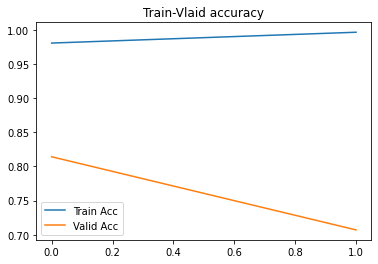

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


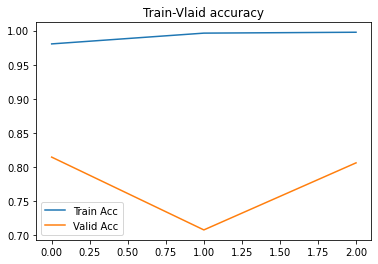

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


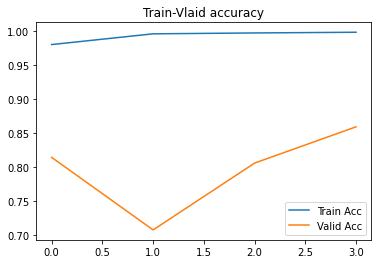

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


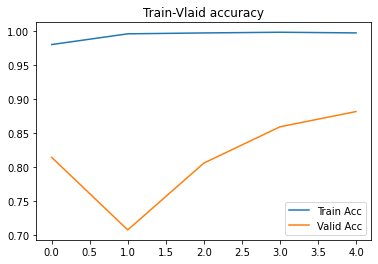

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb